In [1]:
#!pip install pandasql
#! pip install veroviz
#!pip install pmdarima
#!pip install sklearn

In [2]:
#importing libraries
import pandas as pd
import numpy as np
import glob
import veroviz as vrv
import matplotlib.pyplot as plt
import pmdarima as pm
import datetime
import warnings
import time

In [3]:
#importing packages from the libraries
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from pmdarima.model_selection import train_test_split
from datetime import datetime
warnings.filterwarnings('ignore')
from pandasql import sqldf

In [4]:
pwd

'C:\\Users\\dkesa\\Box\\Masters\\summer\\E-business and HCM\\data_nz'

In [7]:
#getting the .csv filenames in the directory 
files = glob.glob("C:/Users/dkesa/Box/Masters/summer/E-business and HCM/data_nz/*.csv")

In [8]:
#loading the data into the dataframe initally and using the for loop below to run the append all the files
Traffic = pd.DataFrame(pd.read_csv(files[0]))

In [6]:
#Traffic = pd.concat((pd.read_csv(f) for f in files),ignore_index=True)
# for loading all the files in the directory into dataframe

In [7]:
Traffic.tail()

,TIME,SEGMENT_ID,SPEED,STREET,DIRECTION,FROM_STREET,TO_STREET,LENGTH,STREET_HEADING,COMMENTS,...,RECORD_ID,START_LATITUDE,START_LONGITUDE,END_LATITUDE,END_LONGITUDE,START_LOCATION,END_LOCATION,Community Areas,Zip Codes,Wards
3068525,02/28/2018 05:01:00 PM,1307,16,Clark,SB,Harrison,Roosevelt,0.5,S,NaN,...,1307-201802282301,41.874521,-87.630774,41.867374,-87.630536,POINT (-87.630774 41.874521),POINT (-87.630536 41.867374),38.0,14913,10.0
3068526,02/28/2018 05:01:00 PM,1308,24,Harrison,EB,Canal,State,0.6,W,NaN,...,1308-201802281701,41.874238,-87.639487,41.874452,-87.627611,POINT (-87.639487 41.874238),POINT (-87.627611 41.874452),29.0,14917,26.0
3068527,02/28/2018 05:01:00 PM,1308,24,Harrison,EB,Canal,State,0.6,W,NaN,...,1308-201802282301,41.874238,-87.639487,41.874452,-87.627611,POINT (-87.639487 41.874238),POINT (-87.627611 41.874452),29.0,14917,26.0
3068528,02/28/2018 05:01:00 PM,1309,23,Harrison,WB,Canal,Halsted,0.4,W,NaN,...,1309-201802282301,41.874538,-87.639487,41.874438,-87.647125,POINT (-87.639487 41.874538),POINT (-87.647125 41.874438),29.0,14917,26.0
3068529,02/28/2018 05:01:00 PM,1309,23,Harrison,WB,Canal,Halsted,0.4,W,NaN,...,1309-201802281701,41.874538,-87.639487,41.874438,-87.647125,POINT (-87.639487 41.874538),POINT (-87.647125 41.874438),29.0,14917,26.0


In [8]:
#changing data type to string
Traffic[["FROM_STREET","TO_STREET"]] = Traffic[["FROM_STREET","TO_STREET"]].astype("string")
Traffic.shape

(3068530, 25)

In [9]:
# changing data type to date 
Traffic["TIME"] = pd.to_datetime(Traffic["TIME"],format = '%m/%d/%Y %H:%M:%S %p')
#Traffic.index = pd.to_datetime(Traffic["TIME"],format = '%m/%d/%Y %H:%M:%S %p')

In [10]:
# dropping the columns which are assumed to be unnecessary records
Traffic.drop(["RECORD_ID","COMMENTS","SEGMENT_ID","MESSAGE_COUNT","STREET","DIRECTION","HOUR","DAY_OF_WEEK","MONTH","RECORD_ID","START_LATITUDE","START_LONGITUDE","END_LATITUDE","END_LONGITUDE",
              "Community Areas","Wards","STREET_HEADING","LENGTH","BUS_COUNT","Zip Codes"],axis =1,inplace = True)
Traffic.dtypes

TIME              datetime64[ns]
SPEED                      int64
FROM_STREET               string
TO_STREET                 string
START_LOCATION            object
END_LOCATION              object
dtype: object

In [11]:
# removing invalid or improper speed records
Traffic = Traffic[Traffic["SPEED"]>0]

In [12]:
#removing repeated measure
Traffic = Traffic.drop_duplicates()

In [13]:
Traffic.shape

(1818248, 6)

In [14]:
# getting co-ordinates as list by splitting and joining
def points(x):
  return [float(x.split('POINT (')[1].split(')')[0].split(" ")[1]),float(x.split('POINT (')[1].split(')')[0].split(" ")[0])]

In [15]:
#transforming the records as list of points from string to float
Traffic["Start_point"] = Traffic["START_LOCATION"].apply(lambda x:points(x))

In [16]:
#transforming the records as list of points from string to float
Traffic["End_point"] = Traffic["END_LOCATION"].apply(lambda x:points(x))

In [17]:
#dropping the repeated columns after using it
Traffic.drop(["START_LOCATION","END_LOCATION"],axis =1,inplace = True)

In [18]:
#getting the unique node names
coming_from = list(Traffic["FROM_STREET"].unique())
going_to = list(Traffic["TO_STREET"].unique())

In [19]:
#records = []
#for i in range (0,len(coming_from)):
  #for j in range (0,len(going_to)):
    #records.append(Traffic[(Traffic["FROM_STREET"]== coming_from[i]) &(Traffic["TO_STREET"]==going_to[j])]["SEGMENT_ID"].value_counts())

In [20]:
Traffic.notnull().sum()*100/Traffic.shape[0]   ##checking any null data

TIME           100.0
SPEED          100.0
FROM_STREET    100.0
TO_STREET      100.0
Start_point    100.0
End_point      100.0
dtype: float64

In [21]:
# checking the count of the each values in the records
Traffic.FROM_STREET.value_counts(ascending=False)

Halsted         54596
Ashland         43082
Damen           40864
Western         40318
Roosevelt       34449
                ...  
Orleans           504
Torrence          410
Ogden             208
1550 West          92
Indianapolis        2
Name: FROM_STREET, Length: 145, dtype: Int64

In [22]:
#calculating the distance between the points and using it for calculating the travel avg.time
# as per the queuing theory the overall estiamte average is taken for overall analysis untill for a specific state
def time_taken(x,y,z):
  return vrv.getTimeDistScalar2D(startLoc = x,endLoc = y,routeType='euclidean2D',speedMPS = z)[0]

In [23]:
#applying the function to the column and deriving the time
Traffic["Travel_time"] = Traffic.apply(lambda Traffic : time_taken(Traffic["Start_point"],Traffic["End_point"],Traffic["SPEED"]),axis =1)

In [27]:
#rounding the big float to float
Traffic["Travel_time"] = Traffic["Travel_time"].round(3)

In [24]:
#Traffic.sort_values(['TIME','SEGMENT_ID'], ascending=True,inplace=True)

In [25]:
#def segregation (a,b):
  #return Traffic[(Traffic["FROM_STREET"] == a) & (Traffic["TO_STREET"] == b )][["TIME","Travel_time"]]


In [26]:
#segrgated_list = []
#for i in range (0,len(coming_from)):
  #for j in range (0,len(going_to)):
    #if (coming_from[i] != going_to[j]) and (len(segregation(coming_from[i],going_to[j]))>10):
      #segrgated_list.append([segregation(coming_from[i],going_to[j])])

In [ ]:
#Traffic.merge(Traffic,on= 'FROM_STREET')

In [ ]:
#initial = Traffic[(Traffic["FROM_STREET"] == coming_from[0]) & (Traffic["TO_STREET"] == going_to[0] )]

In [ ]:
#initial = initial.drop_duplicates("TIME")

In [ ]:
#initial = initial.set_index("TIME")

In [29]:
#dropping repeated time measures
Traffic.drop(["SPEED","End_point","Start_point"],axis=1,inplace= True)

In [30]:
#dropping repeated time measures
Traffic = Traffic.drop_duplicates(subset=["TIME","FROM_STREET","TO_STREET"])

In [166]:
query = 'SELECT TIME,Travel_time,FROM_STREET,TO_STREET from Traffic order by FROM_STREET,TO_STREET,TIME'

In [167]:
pysqldf = lambda q: sqldf(q,globals())

In [168]:
paried_traffic = pysqldf(query)

In [247]:
#getting the pair nodes for the route
routes = paried_traffic.drop_duplicates(subset=["FROM_STREET","TO_STREET"])[["FROM_STREET","TO_STREET"]]

In [170]:
#making 2 nodes as combined
def combined_list(x,y):
  return (str(x)+","+str(y))

In [171]:
#applying the function to the dataframe and getting the list
routes["Travel_route"] = routes.apply(lambda routes : combined_list(routes["FROM_STREET"],routes["TO_STREET"]),axis =1)

In [172]:
travel_routte = list(routes["Travel_route"])

In [174]:
#sql querry for getting the traveldate,time and traveltime for each of valid route ends
query_for = 'SELECT TIME,Travel_Time from Traffic where FROM_STREET = "{from_Street}" and TO_STREET = "{to_Street}" order by TIME'

In [ ]:
#damn it takes 4 hours to create this dictonary from SQL querry
#storing the routes as keys in the dictonary 
# inserting the street names into the querry and getting the data and data into the dictonary as 
#key-value pairs for each route into the dictonary
d={}
for i in travel_routte:
    sql = query_for.format(from_Street = i.split(',')[0],to_Street = i.split(',')[1])
    temp = pysqldf(sql)
    d[i] = pd.DataFrame(temp)
#coming_from = list(Traffic["FROM_STREET"].unique())
#going_to = list(Traffic["TO_STREET"].unique())

In [342]:
useless =[]
for i in d.keys():
    if len(d[i])<150:
        useless.append(i)

In [343]:
for i in useless:
    d.pop(i)

In [213]:
#checking for the stationarity of the data for time series
# Ho : non stationary 
# H1 : stationary
def adfuller_test(Travel_time):
  result = adfuller(Travel_time)
  if result[1]<=0.05:
    print("Ho not satisfied")
  else:
    print("Ho statisfied")

In [ ]:
#checking for non stationary data nodes
not_satisfied=[]
satisfied =[]
for i in d.keys():
    if adfuller_test(d[i]["Travel_time"]) == "Ho not satisfied":
        not_satisfied.append(i)
    else:
        satisfied.append(i)

In [ ]:
#for checking the points that are biased
print(len(not_satisfied),len(staisfied))

In [356]:
#splitting the data into training and validating sets
ml_train = {}
ml_valid = {}
for i in d.keys():
    d[i]["TIME"] = pd.to_datetime(d[i]["TIME"],format = '%Y-%m-%d %H:%M:%S.%f')
    d[i].set_index('TIME',inplace = True)
    ml_train[i] = d[i].head(int(len(d[i])*0.75))
    ml_valid[i] = d[i].tail(len(d[i])-int(len(d[i])*0.75))

In [406]:
#creating the dates for the forecast
extended_dates={}
for i in d.keys():
    extended_dates[i]=pd.date_range(d[i].index[-1],freq = '10T',periods = 1)

In [ ]:
#forecasting the travel time for each route and storing into the dictonary 
#damn it takes 5hrs to run this
forecasted = {}
for i in d.keys():
    forecasted[i]=pd.Series(pm.auto_arima(d[i],seasonal=True,stationary=True,m=1).predict(1),extended_dates[i])

In [245]:
routes_tab = list(d.keys())

In [424]:
data_file = pd.read_csv(files[0])

In [425]:
data_file.drop(["RECORD_ID","TIME","SPEED","COMMENTS","SEGMENT_ID","MESSAGE_COUNT","STREET","DIRECTION","HOUR","DAY_OF_WEEK","MONTH","RECORD_ID","START_LOCATION","END_LOCATION",
              "Community Areas","Wards","STREET_HEADING","LENGTH","BUS_COUNT","Zip Codes"],axis =1,inplace = True)

In [426]:
data_file = data_file.drop_duplicates()

In [427]:
data_file = data_file.drop_duplicates(subset=["FROM_STREET","TO_STREET"])

In [268]:
#getting the file for visualization
data_file.to_csv("routes.csv",index=False)

In [423]:
data_file = data_file.reset_index(drop=True)

<bound method DataFrame.reset_index of               FROM_STREET  TO_STREET  START_LATITUDE  START_LONGITUDE  \
0                  Cermak       31st       41.851245       -87.744434   
1               Roosevelt     Cermak       41.865963       -87.744985   
2                 Madison    Chicago       41.879699       -87.804549   
3                 Chicago  North Ave       41.894268       -87.805101   
4     Forest Preserve Ave   Gunnison       41.953814       -87.807150   
...                   ...        ...             ...              ...   
1024            Milwaukee    Chicago       41.904018       -87.667697   
1026               Elston  North Ave       41.918548       -87.668277   
1027            Fullerton     Elston       41.925153       -87.668330   
1033           Cumberland    Pacific       41.951915       -87.836713   
1037            Bryn Mawr      Clark       41.983475       -87.669632   

      END_LATITUDE  END_LONGITUDE  Distance  
0        41.836747     -87.743932  161

In [428]:
#function to calculate the distance between the points
def distance_btw(a,b,c,d):
  return round(vrv.getTimeDistScalar2D(startLoc= [a,b],endLoc=[c,d],routeType='euclidean2D',speedMPS=30)[1],3)

In [429]:
#extracting the distance between the routes
data_file["Distance"] = data_file.apply(lambda data_file : distance_btw(data_file["START_LATITUDE"],data_file["START_LONGITUDE"],data_file["END_LATITUDE"],data_file["END_LONGITUDE"]),axis=1)

In [435]:
data_file["Distance"][1].dtype

dtype('float64')

In [456]:
#this is the dataframe used for getting the route
nodesDF = pd.read_csv("nodesDF.csv")

In [492]:
#extracting the travel matrix
costDict = [timeSec, distMeters] = vrv.getTimeDist2D(nodes = nodesDF,
                                          routeType = 'euclidean2D',
                                          speedMPS = vrv.convertSpeed(30, 'miles', 'hr', 'meters', 'second'))

In [465]:
#extarcting the nearest nodes to the points as the routes lead to streets and then updating the travel time to the matrix
for i in costDict[1].keys():
    if (i[0] != i[1]): 
        route_nodes = {}
        street_names = {}
        for j in range(0,len(data_file["Distance"])):
            if (costDict[1][i] - data_file["Distance"][j] <=2.5) or (costDict[1][i] - data_file["Distance"][j] <=-2.5) :
                route_nodes[i] = list(data_file.iloc[j][["START_LATITUDE","START_LONGITUDE"]]),list(data_file.iloc[j][["END_LATITUDE","END_LONGITUDE"]])
                street_names[i] = data_file.iloc[[j]][["FROM_STREET","TO_STREET"]]


In [538]:
#updating the matrix if the points are nearer to the forecasted points.
for m in route_nodes.keys():
        if distance_btw(route_nodes[m][0][0],route_nodes[m][0][1],list(nodesDF[nodesDF["id"]==m[0]]["lat"])[0],list(nodesDF[nodesDF["id"]==m[1]]["lon"])[0]) < 2or distance_btw(route_nodes[m][0][0],route_nodes[m][0][1],list(nodesDF[nodesDF["id"]==m[0]]["lat"])[0],list(nodesDF[nodesDF["id"]==m[1]]["lon"])[0]) < -2 or distance_btw(route_nodes[m][1][0],route_nodes[m][1][1],list(nodesDF[nodesDF["id"]==m[0]]["lat"])[0],list(nodesDF[nodesDF["id"]==m[1]]["lon"])[0]) < 2or distance_btw(route_nodes[m][1][0],route_nodes[m][1][1],list(nodesDF[nodesDF["id"]==m[0]]["lat"])[0],list(nodesDF[nodesDF["id"]==m[1]]["lon"])[0]) < -2 :
            costDict[1].update(m = forecasted[combined_list[stret_names[m][0],street_names[m][1]]])
            #print(1)

In [493]:
#getting nearest neighbour for better intial start for the heuristic
def solve_tsp_nn(startNode, costDict, nodesDF):     
    nn_route = []
    # Start our route by visiting the startNode
    nn_route.append(startNode)
    # Initialize a list of unvisited nodes
    unvisitedNodes = list(nodesDF[nodesDF['id'] != startNode]['id'])
    # Let i represent our "current" location:
    i = startNode
    while len(unvisitedNodes) > 0:
        # Initialize minTime to a huge value
        minTime = float('inf')
        # Find the nearest unvisited node to our current node:
        for j in unvisitedNodes:
            if (costDict[i,j] < minTime):
                nextNode = j
                minTime = costDict[i,j]
        # Update our salesperson's location
        i = nextNode
        # Append nextNode to our route:
        nn_route.append(nextNode)
        # Remove nextNode from our list of unvisitedNodes:
        unvisitedNodes.remove(nextNode)
    nn_route.append(startNode)
    return nn_route

In [514]:
nn_route = solve_tsp_nn(0, timeSec, nodesDF)

In [520]:
#the cost for covering the route
def tsp_cost(route, costDict):
  cost = 0
  i = route[0]
  for j in route[1:]:
    cost+= costDict[i,j]
    i=j      
  cost+= costDict[i,route[0]]
  return cost
# tsp_cost(solve_tsp_nn(0, distMeters, nodesDF), distMeters) 

In [504]:
# interchaning the nodes for finding the better route
def tsp_neighbor(route):
    a = np.random.randint(0,len(nn_route)-3)
    b = np.random.randint(a+1, len(nn_route)-2)
    newRoute = []
    newRoute.extend(route[0:a])
    subtour = route[a:b+1]
    subtour.reverse()
    newRoute.extend(subtour)
    newRoute.extend(route[b+1:len(route)-1])
    newRoute.append(newRoute[0])
    return newRoute

In [522]:
#simulated annealing with the initial temeperature of 300k
t0 = 300  
X_0 = solve_tsp_nn(0, timeSec, nodesDF)
X_cur = X_0
Z_cur = tsp_cost(X_cur, timeSec)
T_cur = t0
temp = []
values = []
X_best = X_cur
Z_best = Z_cur
for i in range(1000):
    T_cur = T_cur*0.99
    X_count = tsp_neighbor(X_cur)
    if(tsp_cost(X_count,timeSec) <= Z_cur):
        X_cur = X_count
        Z_cur = tsp_cost(X_count,timeSec)
    else:
        if(np.random.randint(0,1) <= np.exp((Z_cur - tsp_cost(X_count,timeSec))/T_cur)):
            X_cur = X_count
            Z_cur = tsp_cost(X_count,timeSec)
    values.append(Z_cur)
    temp.append(T_cur)
    if(tsp_cost(X_cur,timeSec) < Z_best):
        Z_best = tsp_cost(X_cur,timeSec)
        X_best = X_cur
    if((T_cur < 1)):
        break
    

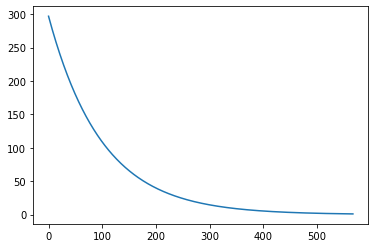

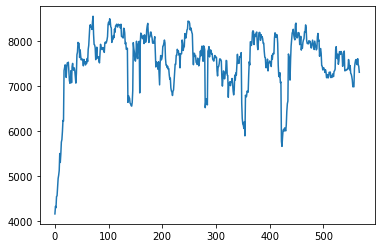

In [523]:
plt.plot(temp)
plt.show()

plt.plot(values) # total cost plot
plt.show()

In [540]:
#visualizing the route
vrv.createLeaflet(nodes= nodesDF, arcs=vrv.createArcsFromNodeSeq(nodeSeq=X_best, nodes=nodesDF))